In [2]:
%matplotlib inline

import cv2 # The OpenCV library; install using `pip install opencv-contrib-python`
import numpy as np # Helpful when working with arrays; install using `pip install numpy`
from matplotlib import pyplot as plt # Good for graphing; install using `pip install matplotlib`
from matplotlib import image as image
import easygui # An easy-to-use file-picker; pip install easygui (mac not supported)

In [3]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)
    return flow


def get_flow_viz(flow):
    """ Obtains BGR image to Visualize the Optical Flow 
        """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

In [4]:
def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    """ Obtains Detection Mask from Optical Flow Magnitude
        Inputs:
            flow_mag (array) Optical Flow magnitude
            motion_thresh - thresold to determine motion
            kernel - kernal for Morphological Operations
        Outputs:
            motion_mask - Binray Motion Mask
        """
    motion_mask = np.uint8(flow_mag > motion_thresh)*255

    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return motion_mask

Text(0.5, 1.0, 'Dense Optical Flow')

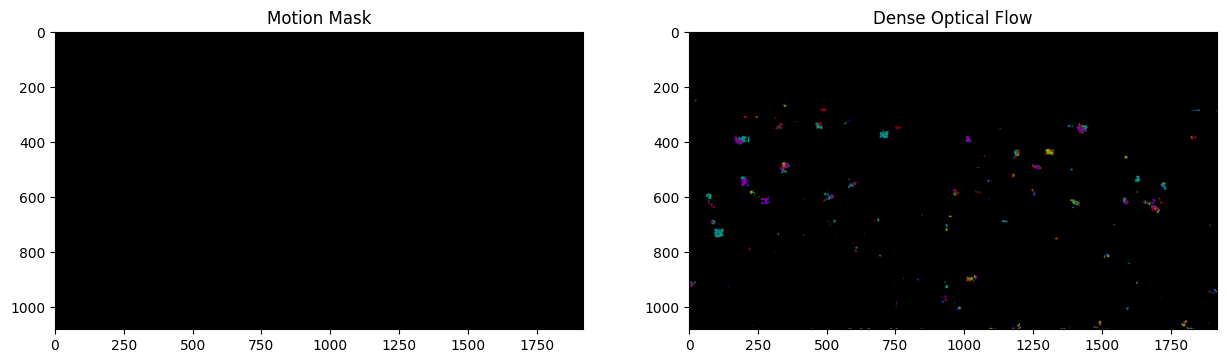

: 

In [5]:
video = cv2.VideoCapture('Images/traffic.mp4')

ret, frame1 = video.read()
ret, frame2 = video.read()

if not ret:
    raise ValueError("Error reading the video file")

flow = compute_flow(frame1, frame2)

mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

rgb = get_flow_viz(flow)

min_thresh = 0.3
max_thresh = 1
motion_thresh = np.c_[np.linspace(min_thresh, max_thresh, 1080)].repeat(1920, axis=-1)

mask = get_motion_mask(mag, motion_thresh=motion_thresh)

# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Motion Mask")
ax[1].imshow(rgb*50) # scale RGB to see the noise
ax[1].set_title("Dense Optical Flow")

In [5]:
video = cv2.VideoCapture('Images/traffic.mp4')

min_thresh = 0.3
max_thresh = 1
motion_thresh = np.c_[np.linspace(min_thresh, max_thresh, 1080)].repeat(1920, axis=-1)

while True:
    ret, frame1 = video.read()
    ret, frame2 = video.read()

    if not ret:
        break

    flow = compute_flow(frame1, frame2)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    mask = get_motion_mask(mag, motion_thresh=motion_thresh)

    cv2.imshow('Motion Mask', mask)
    cv2.imshow('Dense Optical Flow', get_flow_viz(flow))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    
video.release()
cv2.destroyAllWindows()

In [9]:
# Skipping frames to speed up the process (Idk if this is what we should do but its an option)


video = cv2.VideoCapture('Images/traffic.mp4')

min_thresh = 0.3
max_thresh = 1
motion_thresh = np.c_[np.linspace(min_thresh, max_thresh, 1080)].repeat(1920, axis=-1)

skip_frames = 2  # Process every 2nd frame
counter = 0
while True:
    ret, frame1 = video.read()
    counter += 1
    if counter % skip_frames == 0:
        ret, frame2 = video.read()

        if not ret:
            break

        flow = compute_flow(frame1, frame2)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        mask = get_motion_mask(mag, motion_thresh=motion_thresh)

        cv2.imshow('Motion Mask', mask)
        cv2.imshow('Dense Optical Flow', get_flow_viz(flow))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


: 

In [8]:
def get_contour_detections(mask, angle_thresh=2, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the
        mask. Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            angle_thresh - threshold for flow angle standard deviation
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores 
                        [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                    cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                    cv2.CHAIN_APPROX_TC89_L1)
    temp_mask = np.zeros_like(mask) # used to get flow angle of contours
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        # get area of contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        # get flow angle inside of contour
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh):
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

In [12]:
def remove_contained_bboxes(boxes):
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep


def non_max_suppression(boxes, scores, threshold=1e-1):
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

In [19]:
def get_detections(frame1, frame2, motion_thresh=1, bbox_thresh=400, nms_thresh=0.1, mask_kernel=np.ones((7,7), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            motion_thresh - Minimum flow threshold for motion
            bbox_thresh - Minimum threshold area for declaring a bounding box 
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            mask_kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # get optical flow
    flow = compute_flow(frame1, frame2)

    # separate into magntiude and angle
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    motion_mask = get_motion_mask(mag, motion_thresh=motion_thresh, kernel=mask_kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, thresh=bbox_thresh)

    # Check if detections are not empty and have the expected shape
    if detections is None or len(detections) == 0:
        return np.array([])  # Return an empty array if there are no detections
    
    # Make sure detections is a 2D array
    detections = np.atleast_2d(detections)



    # separate bboxes and scores
    bboxes = detections[:, :4]  # First 4 columns should be bounding boxes
    scores = detections[:, -1]  # Last column should be scores

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, threshold=nms_thresh)

In [20]:
video = cv2.VideoCapture('Images/traffic.mp4')

while True:
    ret, frame1 = video.read()
    ret, frame2 = video.read()

    if not ret:
        break

    detections = get_detections(frame1, frame2)

    # draw detections on frame
    for x1, y1, x2, y2 in detections:
        cv2.rectangle(frame1, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2.imshow('Detections', frame1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
video.release()
cv2.destroyAllWindows()



In [1]:
import cv2
import numpy as np

# Initialize video capture
cap = cv2.VideoCapture('Images/traffic.mp4')

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Parameters for feature detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade Optical Flow
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Generate random colors for paths and bounding boxes
color = np.random.randint(0, 255, (100, 3))

# Take the first frame and detect corners to track
ret, old_frame = cap.read()
if not ret:
    print("Error: Failed to read the first frame.")
    cap.release()
    exit()

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing paths
mask = np.zeros_like(old_frame)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical Flow using Lucas-Kanade method
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points (status = 1 means the feature was tracked successfully)
    good_new = p1[st == 1]
    good_old = p0[st == 1]


    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)

    # Overlay the mask with path lines on the current frame
    img = cv2.add(frame, mask)

    # Display the result
    cv2.imshow('Vehicle Tracking with Optical Flow and Bounding Boxes', img)

    # Update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)



2024-11-06 14:31:48.199 python[62247:4469311] +[IMKClient subclass]: chose IMKClient_Legacy
2024-11-06 14:31:48.199 python[62247:4469311] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


-1

: 

In [5]:
import cv2
import numpy as np

# Capture video
cap = cv2.VideoCapture('Images/traffic.mp4')
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Detect initial points to track
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow using Lucas-Kanade method
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select only points that were successfully tracked
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Calculate the speed of each point
        speeds = np.sqrt((good_new[:, 0] - good_old[:, 0])**2 + (good_new[:, 1] - good_old[:, 1])**2)

        # Estimate overall speed (e.g., median speed)
        estimated_speed = np.median(speeds)
        print(f"Estimated speed: {estimated_speed} pixels/frame")

        # Update points for visualization
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 255, 0), -1)
            frame = cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (255, 0, 0), 2)

        # Show the frame with tracks
        cv2.imshow('Lucas-Kanade Optical Flow', frame)

        # Update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Estimated speed: 0.0 pixels/frame
Estimated speed: 0.0 pixels/frame
Estimated speed: 0.0 pixels/frame
Estimated speed: 0.0006169623229652643 pixels/frame
Estimated speed: 0.0002259864704683423 pixels/frame
Estimated speed: 0.0001863266370492056 pixels/frame
Estimated speed: 0.0010912606958299875 pixels/frame
Estimated speed: 0.002922207582741976 pixels/frame
Estimated speed: 0.0 pixels/frame
Estimated speed: 9.1552734375e-05 pixels/frame
Estimated speed: 0.03298299387097359 pixels/frame
Estimated speed: 0.0 pixels/frame
Estimated speed: 0.0011423835530877113 pixels/frame
Estimated speed: 0.0012941278982907534 pixels/frame
Estimated speed: 0.0 pixels/frame
Estimated speed: 0.0909791886806488 pixels/frame
Estimated speed: 0.0005119175184518099 pixels/frame
Estimated speed: 0.0472530797123909 pixels/frame
Estimated speed: 0.07723818719387054 pixels/frame
Estimated speed: 0.0002358598867431283 pixels/frame
Estimated speed: 0.0 pixels/frame
Estimated speed: 0.0002460405812598765 pixels/fram

-1